# 3D-Reconstruction-with-Stereo-Cameras

Authors:

Zhongxia Yan (zxyan@berkeley.edu)

Peter Wang (peterwg@berkeley.edu)

Jeffrey Zhang (jeffzhang1996@berkeley.edu)

# 1.5.1 Starter Code and Data

We basically use python to do the 3d reconstrution. First off, we will import some packages and visualize the data.

In [1]:
import numpy as np
import scipy
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D

## 1. fundamental matrix.m: 

This function computes the fundamental matrix $F$ and residual given the data provided.

In [2]:
def fundamental_matrix(matches):
    N = len(matches)
    x1 = matches[:, 0:2]
    x2 = matches[:, 2:4]
    ones = np.ones((N, 1))
    x1_homo = np.concatenate((x1, ones), axis=1)
    x2_homo = np.concatenate((x2, ones), axis=1)

    def construct_T(x):
        mu = np.mean(x, axis=0)
        std = np.std(np.linalg.norm(x, axis=1))
        T = np.eye(3)
        T[:2, :2] = np.eye(2) / std
        T[:2, 2] = -mu / std
        return T

    T1, T2 = map(construct_T, (x1, x2))

    x1_norm = np.dot(T1, x1_homo.T).T
    x2_norm = np.dot(T2, x2_homo.T).T
    
    # least square to calculate F_star
    A = np.array([
        np.outer(x2i, x1i).reshape((9,)) for x1i, x2i in zip(x1_norm, x2_norm)
    ])
    _, _, V_T = np.linalg.svd(A)
    F_star = V_T[-1].reshape((3, 3))
    
    # reduce rank to 2
    U, s, V_T = np.linalg.svd(F_star)
    s[-1] = 0
    F = np.dot(U, np.diag(s)).dot(V_T)

    # add normalization
    F = T2.T.dot(F).dot(T1)
    
    # calculate residual
    d12 = np.sum(x1_homo * x2_homo.dot(F.T), axis=1) \
        / np.linalg.norm(x2_homo.dot(F.T), axis=1)
    d21 = np.sum(x2_homo * x1_homo.dot(F.T), axis=1) \
        / np.linalg.norm(x1_homo.dot(F.T), axis=1)
    residual = np.mean(d12 ** 2 + d21 ** 2) / 2
    return F, residual

**No, we are not directly optimizing the residuals. When we minimize the SVD when solving the homogeneous system, we are minimizing $|x_1^TFx_2|$ with constraint Frobenius norm $\|F\|_F = 1$, which is the same as minimizing $\frac{|x_1^TFx_2|}{\|F\|_F}$; however, the residual is somewhat different because of the denominators $\|Fx_1\|$ and $\|Fx_2\|$. The relationship can be seen through $\|F\|_F^2 = E[||Fx||^2]$, $x \in \mathcal N(0, I)$: so minimizing the SVD is the same as minimizing the residual assuming we have infinite match pairs and the normalized matched pairs are normally distributed (i.e. $x_1, x_2 \in \mathcal N(0, 1)$). See residual values below.**

Note that for the following optimization problem:

$$\min_f \; ||Af||_2 \; s.t. ||f||_2 = 1$$

We use SVD to solve $f$.

More specifically, according to SVD, $A = U \Sigma V^T$ 

Denote $U = [u_1, u_2, ..., u_n], V = [v_1, v_2, ..., v_n]$ , we have $A = \sum_i \sigma_i u_i v_i^T$

Let $\sigma_1 \geq \sigma_2 \geq ... \geq \sigma_n$, we have

$Av_n = \sum_i \sigma_i u_i v_i^T v_n = \sigma_n u_n$

$\Rightarrow ||Af||_2$ is minimized given $f = v_n$

By reshaping $v_n$, we can get solution $F^*$.

In order to guarantee that the fundamental matrix will be rank of 2, we enforce the constraint by solving following optimization problem:

$$\min_F \; ||F-F^*||_F \; s.t. rank(F)=2$$

This problem can be solved using the singular value decomposition of $F^*$. In particular, if $F^* = USV^T$ , where $ S = diag(s1; s2; s3)$ and $s1 \geq s2 \geq s3$,

Then $F = U S‘V^T$, where $=S’ = diag(s1; s2; 0)$.

## 2. find rotation translation.m: 

This function estimates the extrinsic parameters of the second camera. The function returns a cell array $R$ of all the possible rotation matrices and a cell array $t$ with all the possible translation vectors.

We basically rely on following equations:

$$[t]_x = SZR_{90}S^T$$

$$R = [t]_x ^{-1}E$$

$$E = U \Sigma V^T$$

In [3]:
def find_rotation_translation(E):
    U, s, V_T = np.linalg.svd(E)
    R_90 = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    Rs = []
    ts = []
    t = U[:, -1]
    for U_signed in U, -U:
        for neg_indices in [
            (1, 1, 1), 
            (-1, 1, 1),
            (1, 1, -1),
            (1, -1, -1)
        ]:
            U_i = U_signed * np.array(neg_indices).reshape((1, 3))
            V_i_T = V_T * np.array(neg_indices).reshape((3, 1))
            R = U_i.dot(R_90.T.dot(V_i_T))
            if np.linalg.det(R) < 0:
                continue
            ts.append(U_i[:, -1])
            Rs.append(R)
    return ts, Rs

**See R and t pairs below**

## 3. find 3d points.m

Based on

$$x_1 = P_1 X$$

$$x_2 = P_2 X$$

This function reconstructs the 3D point cloud. In particular, it returns a $N \times 3$ array
called points, where $N$ is the number of the corresponding matches.

In [4]:
def find_3d_points(P1, P2, matches):
    points1 = matches[:, : 2]
    points2 = matches[:, 2 : 4]
    def reconstruction_error(points_3d, points_2d, P):
        ones = np.ones((len(points_3d), 1))
        points_3d_homo = np.concatenate((points_3d, ones), axis=1)
        pred_2d = np.dot(P, points_3d_homo.T).T
        pred_2d = pred_2d[:, :2] / pred_2d[:, 2 : 3]
        return np.mean(np.linalg.norm(points_2d - pred_2d, axis=1))
    td_points = []
    
    for (x1, y1), (x2, y2) in zip(points1, points2):
        P = np.zeros((4, 4))
        P[0] = P1[0] - x1 * P1[2]
        P[1] = P1[1] - y1 * P1[2]
        P[2] = P2[0] - x2 * P2[2]
        P[3] = P2[1] - y2 * P2[2]
        _, _, V_T = np.linalg.svd(P)
        point = V_T[-1]
        point = point[0:3] / point[3]
        td_points.append(point)
    td_points = np.array(td_points)
    rec_err1 = reconstruction_error(td_points, points1, P1)
    rec_err2 = reconstruction_error(td_points, points2, P2)
    return td_points, (rec_err1 + rec_err2) / 2

**We calculate the reconstruction error by find the mean L2 distance between the points in $x_i$ and the points in $P_iX$. See reconstruction error values below.**

## 4. plot 3d.m

This function plots the 3D points in a 3D plot and displays the camera centers for both cameras.

In [30]:
def plot_3d(points, camera1, camera2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(*points.T, cmap='hot')
    ax.scatter(*camera1, c='red')
    ax.scatter(*camera2, c='green')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    min_x, max_x = min(points[:, 0]), max(points[:, 0])
    min_y, max_y = min(points[:, 1]), max(points[:, 1])
    min_z, max_z = min(points[:, 2]), max(points[:, 2])
    max_range = max(max_x - min_x, max_y - min_y, max_z - min_z)
    avg_x = (min_x + max_x) / 2
    avg_y = (min_y + max_y) / 2
    avg_z = (min_z + max_z) / 2
    ax.set_xlim([min(avg_x - max_range / 2, camera1[0], camera1[0]), 
                 max(avg_x + max_range / 2, camera1[0], camera1[0])])
    ax.set_ylim([min(avg_y - max_range / 2, camera1[1], camera1[1]),
                 max(avg_y + max_range / 2, camera1[1], camera1[1])])
    ax.set_zlim([min(avg_z - max_range / 2, camera1[2], camera1[2]),
                 max(avg_z + max_range / 2, camera1[2], camera1[2])])
    plt.show()

## 5. Final results

The part shows our final 3D reconstruction result on library and house. Notice we pick up the best $R, t$.

In [27]:
def reconstruct_3d(object):
    dir = './data/%s/' % object
    matches = np.loadtxt(dir + '%s_matches.txt' % object)
    K1 = scipy.io.loadmat(dir + '%s1_K.mat' % object)['K']
    K2 = scipy.io.loadmat(dir + '%s2_K.mat' % object)['K']
    house1 = mpimg.imread(dir + '%s1.jpg' % object)
    house2 = mpimg.imread(dir + '%s2.jpg' % object)
    
    %matplotlib inline
    
    plt.imshow(np.hstack((house1, house2)))
    width = house1.shape[1]
    for x1, y1, x2, y2 in matches:
        plt.scatter([x1, x2 + width], [y1, y2])
    #     plt.plot([x1, x2 + width], [y1, y2], color='r')
    plt.axis('off')
    plt.show()
    
#     %matplotlib notebook

    F, residual = fundamental_matrix(matches)
    print('F residual:', residual)

    E = K2.T.dot(F).dot(K1)
    P1 = K1.dot(np.concatenate((np.eye(3), np.zeros((3, 1))), axis=1))
    best_n = -float('inf')
    best_tR = None
    for i, (t, R) in enumerate(zip(*find_rotation_translation(E))):
        print('Set', i + 1, ':')
        print('R =', R)
        print('t =', t)
        print()
        P2 = K2.dot(np.concatenate((R, t[:, None]), axis=1))
        points1, err = find_3d_points(P1, P2, matches)
        points2 = np.dot(points1, R.T) + t
        z_all = np.concatenate((points1[:, 2:], points2[:, 2:]), axis=1)
        n_front = np.sum(np.all(z_all > 0, axis=1))
        if n_front > best_n:
            best_n = n_front
            best_tR = (t, R, points1, err)
    t, R, points, err = best_tR
    print('Reconstruction error:', err)
    
    plot_3d(points, np.zeros((3,)), -R.T.dot(t))

### Library reconstruction
Initial points and 3D reconstruction result of the library with appropriate R, t

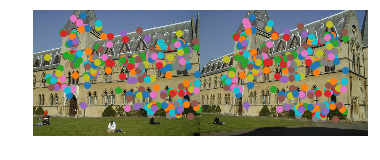

('F residual:', 0.034994662729167868)
('Set', 1, ':')
('R =', array([[ 0.95726096,  0.02656443, -0.2880031 ],
       [-0.02578114,  0.99964639,  0.00651298],
       [ 0.28807428,  0.00119042,  0.95760733]]))
('t =', array([ 0.99833924, -0.00532401, -0.05736221]))
()
('Set', 2, ':')
('R =', array([[ 0.9181869 ,  0.01562518, -0.3958392 ],
       [ 0.01577962, -0.99987139, -0.00286614],
       [-0.39583308, -0.00361454, -0.91831537]]))
('t =', array([ 0.99833924, -0.00532401, -0.05736221]))
()
('Set', 3, ':')
('R =', array([[ 0.95726096,  0.02656443, -0.2880031 ],
       [-0.02578114,  0.99964639,  0.00651298],
       [ 0.28807428,  0.00119042,  0.95760733]]))
('t =', array([-0.99833924,  0.00532401,  0.05736221]))
()
('Set', 4, ':')
('R =', array([[ 0.9181869 ,  0.01562518, -0.3958392 ],
       [ 0.01577962, -0.99987139, -0.00286614],
       [-0.39583308, -0.00361454, -0.91831537]]))
('t =', array([-0.99833924,  0.00532401,  0.05736221]))
()
('Reconstruction error:', 0.31842769380881886)

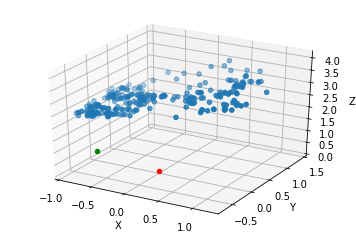

In [31]:
reconstruct_3d('library')

**Output point cloud:** red is camera 1, green is camera 2

Default view:
![Default View](output_library_default.png)

Camera 1 view:
![Camera 1 View](output_library_camera1.png)

Camera 2 view:
![Camera 2 View](output_library_camera2.png)

### House reconstruction
Initial points and 3D reconstruction result of the house with appropriate R, t

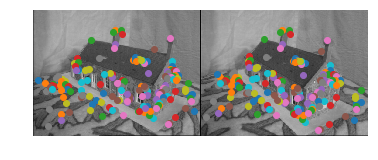

('F residual:', 0.0046822350917829622)
('Set', 1, ':')
('R =', array([[ 0.98579148,  0.06878835, -0.15324267],
       [-0.07018979,  0.99752662, -0.00374756],
       [ 0.15260585,  0.01445038,  0.98818148]]))
('t =', array([ 0.9994141 , -0.02020724,  0.02762459]))
()
('Set', 2, ':')
('R =', array([[ 0.9947433 ,  0.02913419, -0.09816803],
       [ 0.03014519, -0.99950652,  0.00883085],
       [-0.09786231, -0.01174373, -0.99513067]]))
('t =', array([ 0.9994141 , -0.02020724,  0.02762459]))
()
('Set', 3, ':')
('R =', array([[ 0.98579148,  0.06878835, -0.15324267],
       [-0.07018979,  0.99752662, -0.00374756],
       [ 0.15260585,  0.01445038,  0.98818148]]))
('t =', array([-0.9994141 ,  0.02020724, -0.02762459]))
()
('Set', 4, ':')
('R =', array([[ 0.9947433 ,  0.02913419, -0.09816803],
       [ 0.03014519, -0.99950652,  0.00883085],
       [-0.09786231, -0.01174373, -0.99513067]]))
('t =', array([-0.9994141 ,  0.02020724, -0.02762459]))
()
('Reconstruction error:', 0.23888948905653185

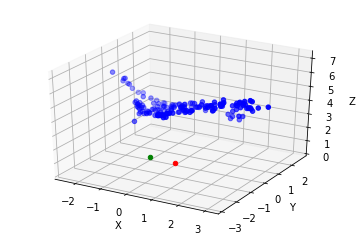

In [29]:
reconstruct_3d('house')

**Output point cloud:** red is camera 1, green is camera 2

Default view:
![Default View](output_house_default.png)

Camera 1 view:
![Camera 1 View](output_house_camera1.png)

Camera 2 view:
![Camera 2 View](output_house_camera2.png)